In [6]:
import os, sys
from datetime import datetime
from pathlib import Path
from types import SimpleNamespace
from typing import Callable, NamedTuple, Tuple
proj = Path.home() / "papercode/variational_sampling_methods"
sys.path.insert(0, str(proj))
# os.environ['PYTHONPATH'] = os.environ.get("PYTHONPATH","") + "~/papercode/variational_sampling_methods"
import hydra
import jax
import matplotlib
import distrax
import jax.numpy as jnp
import numpy as np
import time
import matplotlib.pyplot as plt
from learning.module.target_examples.funnel import Funnel
from learning.module.target_examples.gmm40 import GMM40
import functools
import chex
from omegaconf import OmegaConf
os.environ['HYDRA_FULL_ERROR'] = '1'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'



Setup GMMVI

In [7]:
from learning.module.gmmvi.network import create_gmm_network_and_state


dim=2
key= jax.random.PRNGKey(0)
num_envs=128
batch_size=1024
initial_train_state, gmm_network = create_gmm_network_and_state(dim, num_envs, batch_size, key)


In [8]:

from learning.module.gmmvi.network import GMMTrainingState
from learning.module.target_examples.student_t_mixture import StudentTMixtureModel

target = StudentTMixtureModel(dim=dim, sample_bounds=[-30., 30.], num_components=40)
target = GMM40(dim=dim)
target = Funnel(dim=dim, sample_bounds=[-30, 30])
low = jnp.array([-10,-5])
# low = jnp.array([-target._plot_bound, -target._plot_bound])
high = jnp.array([5, 5])
# high = jnp.array([target._plot_bound, target._plot_bound])

def train_iter(train_state: GMMTrainingState, key: chex.Array, target_log_prob_fn):
    def get_target_grads(samples: chex.Array) -> Tuple[chex.Array, chex.Array]:
        # samples = jnp.where(jnp.logical_or(samples > high, samples < low) , \
        #                     jnp.clip(samples, low, high), samples)
        samples = jnp.clip(samples, low, high)
                            # jax.lax.stop_gradient(jnp.clip(samples, low, high)), samples)
        target, gradient = jax.vmap(jax.value_and_grad(target_log_prob_fn))(samples)
        return gradient, target
    key, subkey = jax.random.split(key)
    new_samples, mapping = gmm_network.sample_selector.select_samples(train_state.model_state,
                                        subkey)

    new_target_grads, new_target_lnpdfs = get_target_grads(new_samples)
    new_sample_db_state = gmm_network.sample_selector.save_samples(train_state.model_state, train_state.sample_db_state, new_samples, new_target_lnpdfs, new_target_grads, mapping)
    samples, mapping, sample_dist_densities, target_lnpdfs, target_lnpdf_grads = \
        gmm_network.sample_selector.select_train_datas(new_sample_db_state)
    # # new_target_grads, new_target_lnpdfs = get_target_grads(low+ (high-low) * jax.nn.sigmoid(new_samples))
    # new_sample_db_state, samples, mapping, sample_dist_densities, target_lnpdfs, target_lnpdf_grads =\
    #     gmm_network.sample_selector.save_samples_and_select(train_state.model_state,
    #                                       train_state.sample_db_state,
    #                                         new_samples,
    #                                         new_target_lnpdfs,
    #                                         new_target_grads,
    #                                         mapping)
    new_component_stepsizes = gmm_network.component_stepsize_fn(train_state.model_state)
    new_model_state = gmm_network.model.update_stepsizes(train_state.model_state, new_component_stepsizes)
    expected_hessian_neg, expected_grad_neg = gmm_network.ng_estimator(new_model_state,
                                                            samples,
                                                            sample_dist_densities,
                                                            target_lnpdfs,
                                                            target_lnpdf_grads)
    new_model_state = gmm_network.component_updater(new_model_state,
                                    expected_hessian_neg,
                                    expected_grad_neg,
                                    new_model_state.stepsizes)

    # new_weight_stepsize_adapter_state = weight_stepsize_adapter.update_stepsize(train_state.weight_stepsize_adapter_state, new_model_state)
    new_model_state = gmm_network.weight_updater(new_model_state, samples, sample_dist_densities, target_lnpdfs,
                                                    train_state.weight_stepsize)
    new_num_updates = train_state.num_updates + 1
    key, subkey = jax.random.split(key)
    new_model_state, new_component_adapter_state, new_sample_db_state = \
        gmm_network.component_adapter(train_state.component_adaptation_state,
                                                    new_sample_db_state,
                                                    new_model_state,
                                                    new_num_updates,
                                                    subkey)
    return GMMTrainingState(temperature=train_state.temperature,
                        model_state=new_model_state,
                        component_adaptation_state=new_component_adapter_state,
                        num_updates=new_num_updates,
                        sample_db_state=new_sample_db_state,
                        weight_stepsize=train_state.weight_stepsize)
def eval(seed: chex.Array, train_state: GMMTrainingState, target_log_prob_fn, n_eval_samples, target_samples=None):
    samples = gmm_network.model.sample(train_state.model_state.gmm_state, seed, n_eval_samples)[0]
    log_prob_model_fn = jax.vmap(functools.partial(gmm_network.model.log_density, gmm_state=train_state.model_state.gmm_state))
    log_prob_model = log_prob_model_fn(sample=samples)
    # log_prob_model = jax.vmap(gmm_network.model.log_density, in_axes=(None, 0))(train_state.model_state.gmm_state, samples)
    log_prob_target = jax.vmap(target_log_prob_fn)(samples)
    log_ratio = log_prob_target - log_prob_model

    if target_samples is not None:
        fwd_log_prob_model = jax.vmap(gmm_network.model.log_density, in_axes=(None, 0))(train_state.model_state.gmm_state, target_samples)
        fwd_log_prob_target = jax.vmap(target_log_prob_fn)(target_samples)
        fwd_log_ratio = fwd_log_prob_target - fwd_log_prob_model
    else:
        fwd_log_ratio = None

    return samples, log_ratio, log_prob_target, fwd_log_ratio, n_eval_samples, log_prob_model_fn


In [9]:
from time import time

import wandb

from learning.module.target_examples.student_t_mixture import StudentTMixtureModel


logger = {
    'KL/elbo': [],
    'KL/eubo': [],
    'logZ/delta_forward': [],
    'logZ/forward': [],
    'logZ/delta_reverse': [],
    'logZ/reverse': [],
    'ESS/forward': [],
    'ESS/reverse': [],
    'discrepancies/mmd': [],
    'discrepancies/sd': [],
    'other/target_log_prob': [],
    'other/EMC': [],
    "stats/step": [],
    "stats/wallclock": [],
    "stats/nfe": [],
}
def eval_fn(samples, log_ratio, target_log_prob, fwd_log_ratio, n_eval_samples, model_log_prob_fn):
    ln_z = jax.nn.logsumexp(log_ratio) - jnp.log(n_eval_samples)
    elbo = jnp.mean(log_ratio)

    if target.log_Z is not None:
        logger['logZ/delta_reverse'].append(jnp.abs(ln_z - target.log_Z))

    logger['logZ/reverse'].append(ln_z)
    logger['KL/elbo'].append(elbo)
    # logger['ESS/reverse'].append(compute_reverse_ess(log_ratio, n_eval_samples))
    logger['other/target_log_prob'].append(jnp.mean(target_log_prob))

    # if cfg.compute_forward_metrics and (target_samples is not None):
    #     eubo = jnp.mean(fwd_log_ratio)
    #     fwd_ln_z = - (jax.scipy.special.logsumexp(-fwd_log_ratio) - jnp.log(cfg.eval_samples))
    #     fwd_ess = jnp.exp(fwd_ln_z - (jax.scipy.special.logsumexp(fwd_log_ratio) - jnp.log(cfg.eval_samples)))

    #     if target.log_Z is not None:
    #         logger['logZ/delta_forward'].append(jnp.abs(fwd_ln_z - target.log_Z))
    #     logger['logZ/forward'].append(fwd_ln_z)
    #     logger['KL/eubo'].append(eubo)
    #     logger['ESS/forward'].append(fwd_ess)

    logger.update(target.visualise(samples=samples, model_log_prob_fn=model_log_prob_fn ,show=True))

    # if cfg.compute_emc and cfg.target.has_entropy:
    #     logger['other/EMC'].append(target.entropy(samples))

    # for d in cfg.discrepancies:
    #     logger[f'discrepancies/{d}'].append(getattr(discrepancies, f'compute_{d}')(target_samples, samples,
    #                                                                                 cfg) if target_samples is not None else jnp.inf)
    # if cfg.moving_average.use_ma:
    #     logger.update(moving_averages(logger, window_size=cfg.moving_average.window_size))

    # if cfg.save_samples:
    #     save_samples(cfg, logger, samples)

    return logger



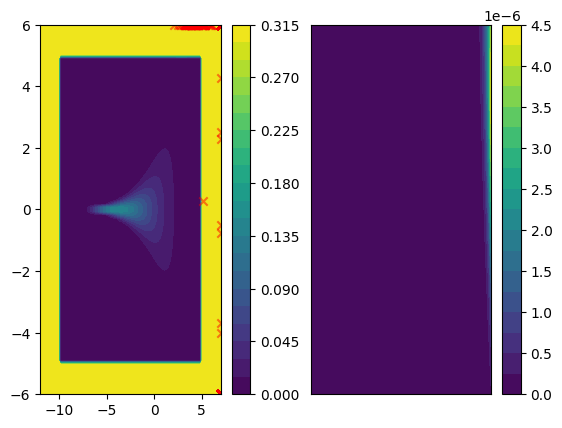

30/3000: The model now has 10 components 


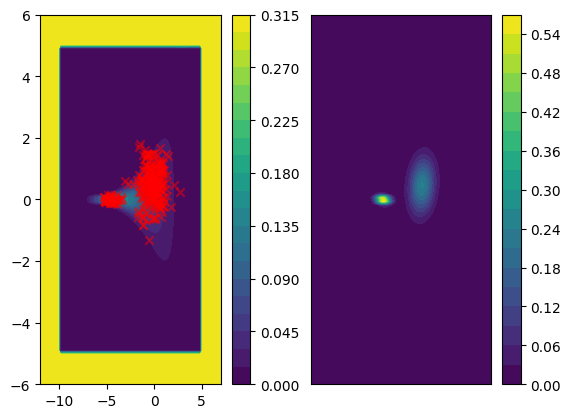

60/3000: The model now has 10 components 


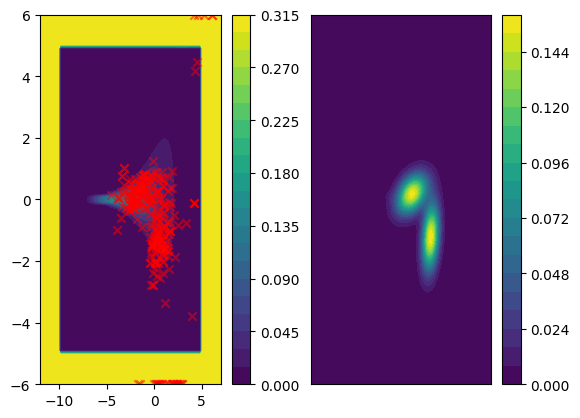

90/3000: The model now has 10 components 


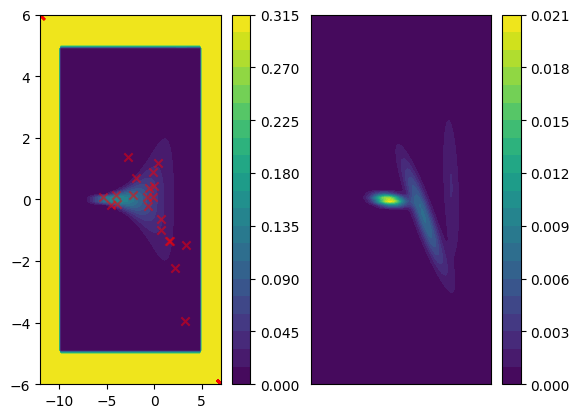

120/3000: The model now has 10 components 


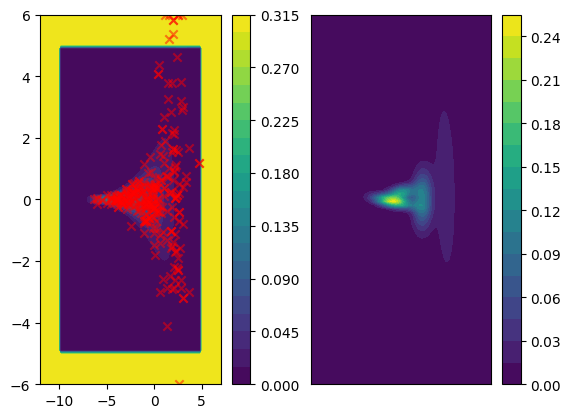

150/3000: The model now has 10 components 


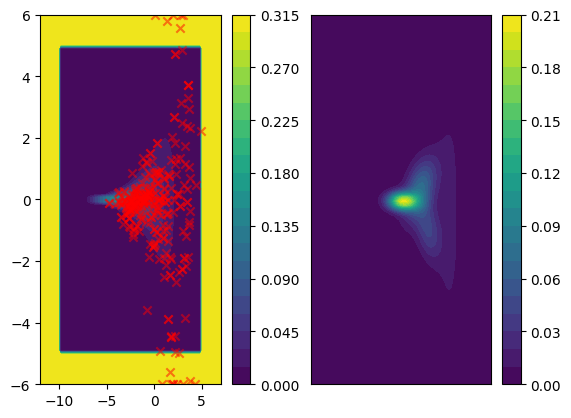

180/3000: The model now has 10 components 


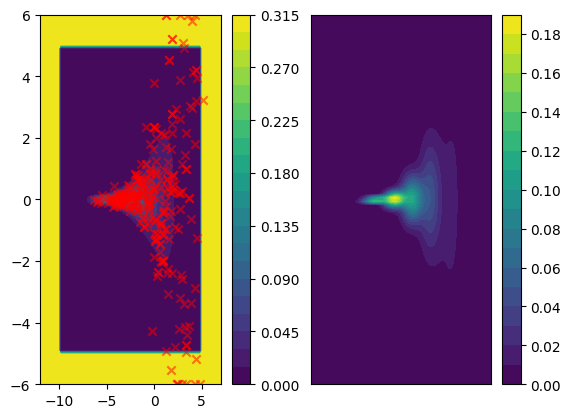

210/3000: The model now has 10 components 


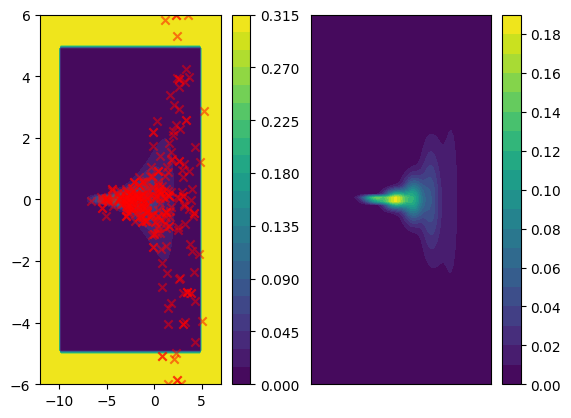

240/3000: The model now has 10 components 


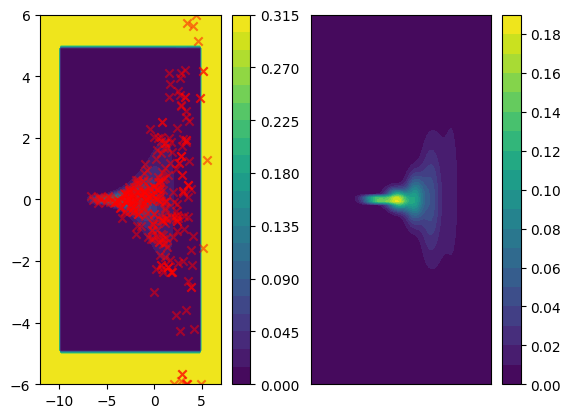

270/3000: The model now has 10 components 


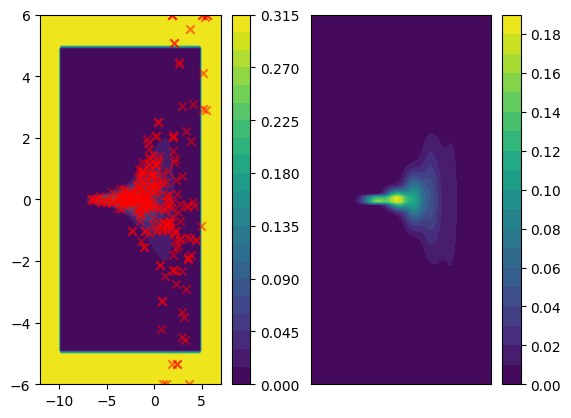

300/3000: The model now has 10 components 


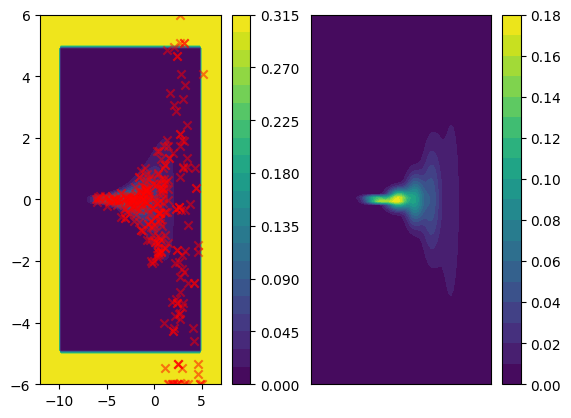

330/3000: The model now has 10 components 


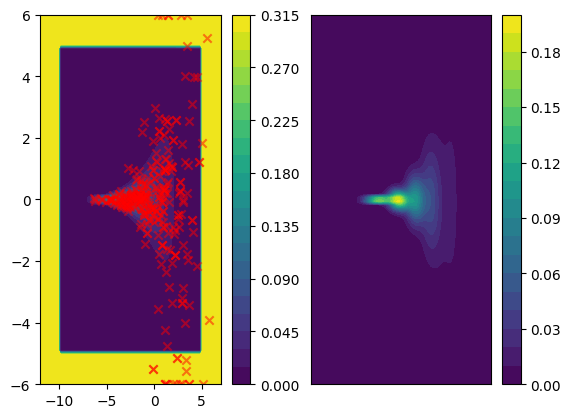

360/3000: The model now has 10 components 


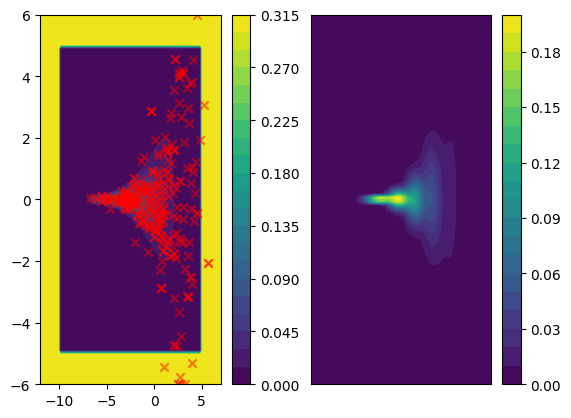

390/3000: The model now has 10 components 


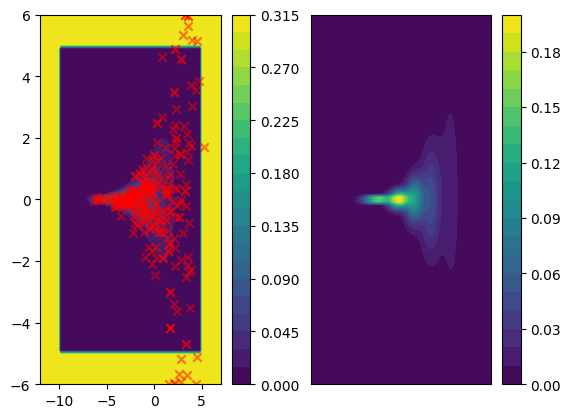

420/3000: The model now has 10 components 


In [ ]:
iterations = 3000
seed=0
num_evals = 100
eval_freq = iterations//num_evals
n_eval_samples= 1000
target_samples = target.sample(jax.random.PRNGKey(0), (n_eval_samples,))
target_log_prob = jax.jit(lambda x : target.log_prob(x))
rng =jax.random.PRNGKey(seed)
key, rng = jax.random.split(rng)
timer = 0
state = initial_train_state

def _insert_buffer(train_state: GMMTrainingState, key: chex.Array, target_log_prob_fn):
    def get_target_grads(samples: chex.Array) -> Tuple[chex.Array, chex.Array]:
        samples = jnp.clip(samples, low, high)
        target, gradient = jax.vmap(jax.value_and_grad(target_log_prob_fn))(samples)
        return gradient, target
    key, subkey = jax.random.split(key)
    new_samples, mapping = gmm_network.sample_selector.select_samples(train_state.model_state,
                                        subkey)
    new_target_grads, new_target_lnpdfs = get_target_grads(new_samples)
    new_sample_db_state = gmm_network.sample_selector.save_samples(train_state.model_state, train_state.sample_db_state, new_samples, new_target_lnpdfs, new_target_grads, mapping)
    return train_state._replace(sample_db_state=new_sample_db_state)
def _train(carry, _):
    state, key = carry
    key, subkey = jax.random.split(key)
    state = train_iter(state, subkey, target_log_prob)
    return (state, key), _

for _ in range(batch_size//num_envs):
    key, subkey = jax.random.split(key)
    state = _insert_buffer(state, key, target_log_prob)

for step in range(0, iterations):
    iter_time = time()
    key, subkey = jax.random.split(key)
    
    # state = train_iter(state, subkey, target_log_prob)
    (state, _), _ = jax.lax.scan(_train, (state, subkey), (), length=eval_freq)
    step+=eval_freq
    timer += time() - iter_time
    if (step % eval_freq == 0) or (step == iterations - 1):
        key, subkey = jax.random.split(key)
        logger = eval_fn(*eval(subkey, state, target_log_prob, n_eval_samples, target_samples))
        logger["stats/step"].append(step)
        logger["stats/wallclock"].append(timer)
        logger['stats/num_samples'] = [state.sample_db_state.num_samples_written]
        logger['stats/num_components'] = [state.model_state.gmm_state.num_components]
        print(f"{step}/{iterations}: "
                f"The model now has {state.model_state.gmm_state.num_components} components ")

